In [1]:
!pip install langgraph langchain langchain-openai langchain_community


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = ""
llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)

In [40]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI


def analyze_question(state):
    
    llm = ChatOpenAI()
    
    prompt = PromptTemplate.from_template("""
    당신은 사용자 질문이 기술적인 코드 관련 질문인지 일반적인 질문인지 정의해야 하는 에이전트입니다.
    
    Question : {input}
    
    질문을 분석하세요. 질문이 기술적 개발에 관한 것이라면 "code"라고 답변하고, 그렇지 않다면 "general"이라고 답변하세요.

    당신의 답변 (code/general) :
    """)

    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    decision = response.content.strip().lower()
    return {"decision":decision, "input": state["input"]}

def code_question(state):
    
    llm = ChatOpenAI()
    
    prompt = PromptTemplate.from_template(
    "당신은 소프트웨어 엔지니어입니다. 이 질문에 대해 단계별로 자세히 답변하세요: {input}"
    )
    
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    
    return {"output":response}

def general_question(state):
    
    llm = ChatOpenAI()

    prompt = PromptTemplate.from_template(
    "질문에 대해 일반적이고 간결하게 답변하세요: {input}"
    )
    
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    
    return {"output":response}

In [41]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict

class AgentState(TypedDict):
    input: str
    output: str
    decision: str

workflow = StateGraph(AgentState)

workflow.add_node("analyze", analyze_question)
workflow.add_node("code_agent", code_question)
workflow.add_node("generic_agent", general_question)

workflow.add_conditional_edges(
    "analyze",
    lambda x: x["decision"],
    {
        "code": "code_agent",
        "general": "generic_agent"
    }
)

workflow.set_entry_point("analyze")

workflow.add_edge("code_agent", END)
workflow.add_edge("generic_agent", END)

graph = workflow.compile()

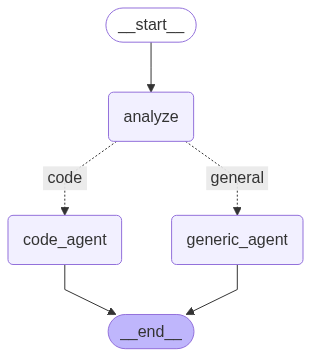

In [42]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [44]:
result = graph.invoke({"input": "프롬프트란?"})

In [45]:
from pprint import pprint

pprint(result)

{'decision': 'general',
 'input': '프롬프트란?',
 'output': AIMessage(content='프롬프트는 컴퓨터 프로그램이나 시스템에서 사용자로부터 명령을 입력받을 수 있도록 대기하고 있는 상태를 말합니다. 사용자가 명령을 입력하면 프롬프트는 해당 명령을 해석하고 실행합니다. 주로 명령 프롬프트나 콘솔 창에서 사용됩니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 39, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-78f4782c-eb67-4543-801c-d1dab860a8b0-0', usage_metadata={'input_tokens': 39, 'output_tokens': 113, 'total_tokens': 152, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
